#DNN_Xavier Init/DNN Layer#5(784->512->512->512->512->10)/Adam/Cross Entropy/Dropout(0.3)
plus. Checking Overfitting: 학습진행도에 따른 Train data와 Test data의 Accuracy와 Error<br>
손글씨 분류기

###ML 라이브러리: Pytorch(GPU)

In [1]:
import torch
# torch.vision 라이브러리: 유명한 datasets, 모델 아키텍터, 이미지 transformation(영상 전처리)
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

GPU 사용을 명시적으로 보여주기 & Random Seed 고정하기

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777) #파이썬의 Random Seed
torch.manual_seed(777) #torch의 Random Seed
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

학습 파라미터 설정

In [3]:
learning_rate = 0.001 #갱신 step의 정도
training_epochs = 15 #epoch
batch_size = 100 #batch
drop_prob = 0.3 #Dropout 확률값

##1. 데이터셋 불러오기

In [4]:
#torchvision.datasets.MNIST(root = 'MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
#root: 데이터셋의 위치
#train = True: 학습 데이터, train = False: 테스트 데이터
#transform = transforms.ToTensor(): 텐서로 영상 전처리
#download = True: root에 데이터셋이 없으면 다운로드
mnist_train = data.MNIST(root='MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)

mnist_test = data.MNIST(root='MNIST_data/', train=False, transform=transforms.ToTensor(), download=True)

DataLoader: 데이터를 알맞게 나눠준다

1. train_loader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
#dataset = mnist_train: 처리할 데이터
#batch_size = batch_size: batch_size만큼씩 데이터를 잘라러 준다
#shuffle = True: 데이터를 섞는다
#drop_last: 모든 데이터 개수 % batch_size > 0 일 때 나머지 데이터를 버린다

2. test_loader

In [6]:
# Shuffle 끄기
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

##5. 모델 추정

###모델 정의: DNN_Xavier Init/NN Layer#5(784->512->512->512->512->10)/Adam/Cross Entropy/Dropout(0.3)

NN Layer #5: 784 -> 512 -> 512 -> 512 -> 512 -> 10 & Dropout(0.3)

In [7]:
linear1 = torch.nn.Linear(784, 512, bias = True) #784 dimension -> 256 dimension
linear2 = torch.nn.Linear(512, 512, bias = True)
linear3 = torch.nn.Linear(512, 512, bias = True)
linear4 = torch.nn.Linear(512, 512, bias = True)
linear5 = torch.nn.Linear(512, 10, bias = True) #256 dimension -> 10 class
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p = drop_prob)

Weight Initialization: Xavier Init

In [8]:
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

.Sequential로 모델을 순서대로 묶는다<br>
.to(device): device = 'cuda' 모델을 gpu 메모리에 저장한다

In [9]:
# 마지막 layer에는 ReLU가 없는 것이 좋다
# layer1(linear1 & ReLU) -> layer2(linear2 & ReLU) -> layer3(linear3 & ReLU) -> layer4(linear4 & ReLU) -> layer5(linear5)
model = torch.nn.Sequential(linear1,relu,dropout,
                            linear2,relu,dropout,
                            linear3,relu,dropout,
                            linear4,relu,dropout,
                            linear5).to(device)

In [10]:
model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=512, out_features=10, bias=True)
)

###모델 학습 & 학습진행도에 따른 Train data와 Test data의 Accuracy와 Error

Cross Entropy Loss & Adam

In [11]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [12]:
plt_acc = [] # accuracy를 위한 좌표 평면
plt_los = [] # error를 위한 좌표 평면

# _batch = 전체 데이터 수 / batch_size
train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    model.train() # 주의사항: Dropout = True(Dropout 활성화)
    for X, Y in train_loader: #앞에서 알맞게 나눠둔 데이터를 X, Y에 넣어준다

        # (mini batch_size, 1, 가로, 세로)
        # (100, 1, 28, 28) 크기의 텐서를 (100, 28*28) 크기의 텐서로 바꿔준다
        X = X.view(-1, 28 * 28).to(device) # 2D 데이터를 1D 데이터로 눌러준다
        # One-hot Encoding되어 있지 않다
        Y = Y.to(device)

        #Gradient Initialization
        optimizer.zero_grad()

        # Forward 계산
        hypothesis = model(X)

        # Cost : Error 계산
        cost = loss(hypothesis, Y)

        # Backpropagation
        cost.backward()

        # Cost로 가중치(W, b) 갱신
        optimizer.step()

        #평균 Error 계산
        avg_cost += cost / train_total_batch
    
    # 학습진행도(epoch, iteration)에 따른 Train data의 accuracy와 error
    with torch.no_grad(): #모델 평가 중: 임시로 required_grad = False로 설정하는 것과 같다
        model.eval()  # 주의사항: Dropout = False(Dropout 비활성화)

        train_accuracy = 0
        train_loss = 0

        for i, (_X, _Y) in enumerate(train_loader):
            _X = _X.view(-1, 28 * 28).to(device)
            _Y = _Y.to(device)

            prediction = model(_X)
            correct_prediction = torch.argmax(prediction, 1) == _Y
            train_loss += loss(prediction, _Y)
            train_accuracy += correct_prediction.float().mean()

        train_acc = train_accuracy.item()/train_total_batch
        train_los = train_loss.item()/train_total_batch
        print('Train Accuracy:', train_acc, 'Train Loss:', train_los )
    

    # 학습진행도(epoch, iteration)에 따른 Test data의 accuracy와 error
    with torch.no_grad(): #모델 평가 중: 임시로 required_grad = False로 설정하는 것과 같다
        model.eval()  # 주의사항: Dropout = False(Dropout 비활성화)

        test_accuracy = 0
        test_loss = 0

        for i, (_X, _Y) in enumerate(test_loader):
            _X = _X.view(-1, 28 * 28).to(device)
            _Y = _Y.to(device)

            prediction = model(_X)
            correct_prediction = torch.argmax(prediction, 1) == _Y
            test_loss += loss(prediction, _Y)
            test_accuracy += correct_prediction.float().mean()
        
        test_acc = test_accuracy.item()/test_total_batch
        test_los = test_loss.item()/test_total_batch
        print('Test Accuracy:', test_acc, 'Test Loss:', test_los )


    plt_acc.append([train_acc, test_acc])
    plt_los.append([train_los, test_los])

print('Learning finished')

Train Accuracy: 0.965266825358073 Train Loss: 0.11279496510823568
Test Accuracy: 0.9620999908447265 Test Loss: 0.12531682968139649
Train Accuracy: 0.9769160970052083 Train Loss: 0.07887170791625976
Test Accuracy: 0.9722998046875 Test Loss: 0.09710775375366211
Train Accuracy: 0.9814828491210937 Train Loss: 0.060828450520833334
Test Accuracy: 0.9756999969482422 Test Loss: 0.08566385269165039
Train Accuracy: 0.9866982014973958 Train Loss: 0.04270816485087077
Test Accuracy: 0.9782999420166015 Test Loss: 0.07410688400268554
Train Accuracy: 0.9886982218424479 Train Loss: 0.038049691518147785
Test Accuracy: 0.9778001403808594 Test Loss: 0.07783629894256591
Train Accuracy: 0.99011474609375 Train Loss: 0.03205962498982747
Test Accuracy: 0.9811000061035157 Test Loss: 0.06662901401519776
Train Accuracy: 0.9915151977539063 Train Loss: 0.027630898157755535
Test Accuracy: 0.9794003295898438 Test Loss: 0.07485657215118408
Train Accuracy: 0.9927151489257813 Train Loss: 0.023823019663492838
Test Accura

##6. 결과 분석

Accuracy

In [13]:
#앞서 모델 학습 과정에서는 required_grad = True로 되어있어 학습 중임을 나타낸다
#False는 학습 중이 아님을, 모델 평가 중임을 나타낸다

with torch.no_grad(): #임시로 required_grad = False로 설정하는 것과 같다

  model.eval() # 주의사항: Dropout = False(Dropout 비활성화)

  test_accuracy = 0

  for i, (_X, _Y) in enumerate(test_loader):
    _X = _X.view(-1, 28 * 28).to(device)
    _Y = _Y.to(device)

    prediction = model(_X)

    correct_prediction = torch.argmax(prediction, 1) == _Y

    test_accuracy += correct_prediction.float().mean()
  
  test_acc = test_accuracy.item() / test_total_batch

  print('Test Accuracy:', test_acc)  

Test Accuracy: 0.9844999694824219


학습진행도에 따른 Test data와 Train data의 Accuracy와 Error

In [14]:
import matplotlib.pyplot as plt

def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='train')
    plt.plot(nn, label='test')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

1. Accuracy

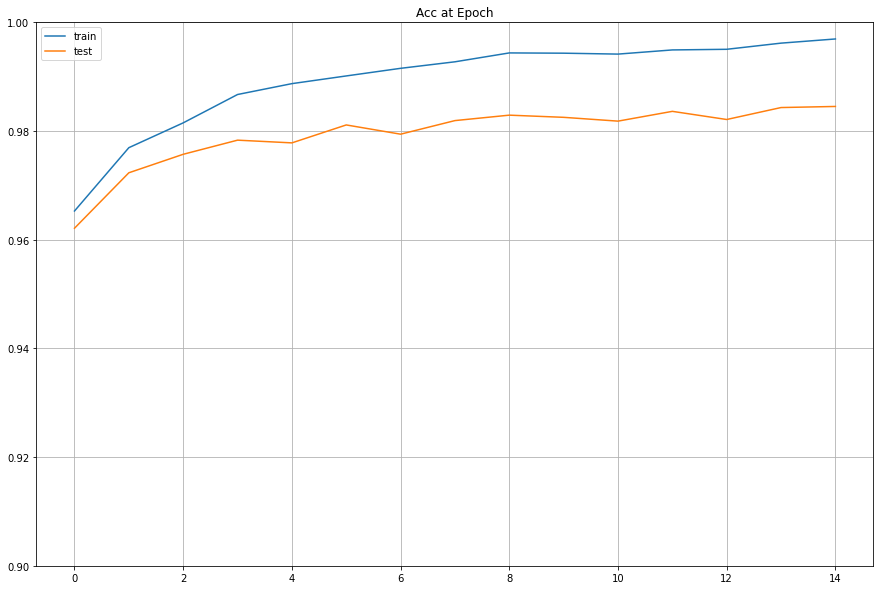

In [15]:
plot_compare(plt_acc , [0.9, 1.0], title='Acc at Epoch')

2. Error

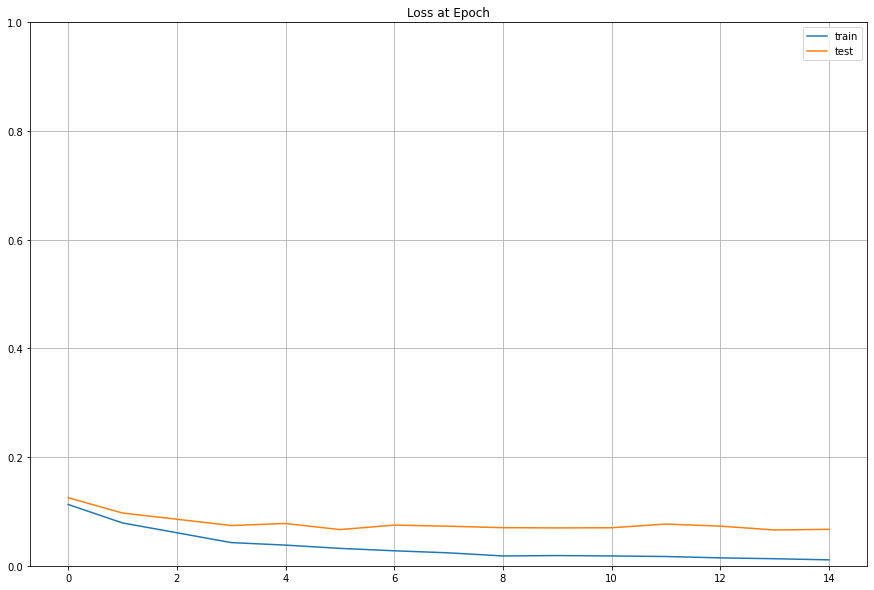

In [16]:
plot_compare(plt_los , [0.0, 1.0], title='Loss at Epoch')